# Portfolio Optimization
Given a list of selected stocks, returns a portfolio

## Load relevant libraries

In [1]:
# Data management
import numpy as np
import pandas as pd

# For plotting 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # for styling dates

from plotly.offline import plot 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import cufflinks as cf # an addon to plotly
# Use plotly locally
cf.go_offline()

# For managing files
import time
import datetime as dt
import os
from os import listdir
from os.path import isfile, join

# For managing warnings
import warnings
warnings.simplefilter("ignore")

## Constants

In [2]:
PATH = "D:\\webScrapping\\derekBanasTutorial\\wilshire_top\\"
stocks_path = "D:\\webScrapping\\derekBanasTutorial\\wilshire_stocks\\"

# Start & end dates default
S_DATE = '2019-07-11'  
E_DATE = '2022-04-2'
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

risk_free_rate = 0.0125 # Approximate 10 year bond rate

# portfolio = ['ZNGA', 'VG', 'ADM', 'MKC', 'HSY', 'XEL', 'EXC', 'VRS', 'HCC',
            #   'BCC', 'WHD', 'OAS', 'EGY']

# Weekly
portfolio = ['LYV', 'VG', 'MU','LIN', 'FCX', 'NSA', 'EXR', 'CBRE', 'REXR',
              'PLD','COST', 'MKC', 'HSY', 'EXC']
num_stocks = len(portfolio)

## Previous functions

In [3]:
def get_stock_df_from_csv(ticker):
    try:
        df = pd.read_csv(stocks_path + ticker + '.csv', index_col=0)
        
        # Check if df has duplicate indexes
        # Sometimes yahoo data comes duplicated
        if not df.index.is_unique:
            df = df.loc[~df.index.duplicated(), :] # ~ is the "invert" or "complement" operation
            # is the bitwise complement operator in python which essentially calculates -x - 1
            
    except FileNotFoundError:
        print("File doesn't exist!")
    else:
        return df

## Merge multiple stocks dataframes into one by column name
By price ("Close") and by cumulative returns ("cum_return") calculated in the previous file "technicalAnalysis.ipynb"

In [4]:
def merge_df_by_column_name(col_name, sdate, edate, tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_stock_df_from_csv(x)
        
        # THIS WAS ORIGINALLY HERE
        # Check if df has duplicate indexes 
        # Sometimes yahoo data comes duplicated
        # if not df.index.is_unique:
        #     df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

mult_df = merge_df_by_column_name('Close', S_DATE, E_DATE, portfolio)
mult_cum_df = merge_df_by_column_name('cum_return', S_DATE, E_DATE, portfolio)

## Calculate mean returns
I need to undersand why he uses log returns instead of arithmetic returns

In [5]:
# Returns from closing price
returns = np.log(mult_df / mult_df.shift(1)) 
# returns = (mult_df / mult_df.shift(1)) - 1 # Daily returns
mean_ret = returns.mean() * 252 # 252 trading days in a year

# Returns from cumulative returns
# cum_returns = np.log(mult_cum_df / mult_cum_df.shift(1)) 
# cum_mean_ret = cum_returns.mean() * 252 # 252 trading days in a year

## Find the correlation between the returns of these stocks
Check pd.corr(), how it is called here, it calculates the ratio of the covariance to the standard deviation
if x and y are stocks:

$r = \frac{\sum_{i} \left( \left(x_{i} - \hat{x} \right) \left(y_{i} - \hat{y} \right)\right)}{\left(\sqrt{\sum_{i}\left(x_{i} - \hat{x} \right)^{2}}\sqrt{\sum_{i}\left(y_{i} - \hat{y} \right)^{2}}\right)}$

where $\hat{x}$ is the mean of x

This is a normalized measurement of the covariance, such that the result always has a value between −1 and 1. 

As it is, it measures the linear correlation between variables. 

You are looking for correlations smaller than 0.5

In [6]:
# These two output the same result, no point in running the two at the same time
corr_returns = returns.corr()
# corr_cum_returns = cum_returns.corr()
corr_returns.style.background_gradient() # plots a default heatmap

,LYV,VG,MU,LIN,FCX,NSA,EXR,CBRE,REXR,PLD,COST,MKC,HSY,EXC
LYV,1.000000,0.401072,0.476208,0.489165,0.485450,0.370144,0.243097,0.536833,0.444021,0.412649,0.160258,0.093961,0.303076,0.424199
VG,0.401072,1.000000,0.387188,0.386988,0.381764,0.287833,0.151110,0.330854,0.337010,0.332507,0.232905,0.148744,0.287184,0.304849
MU,0.476208,0.387188,1.000000,0.540843,0.529794,0.339442,0.261836,0.512730,0.468748,0.464807,0.420470,0.275243,0.352482,0.501843
LIN,0.489165,0.386988,0.540843,1.000000,0.605627,0.463353,0.413170,0.593471,0.586346,0.632007,0.511319,0.455060,0.508794,0.642952
FCX,0.485450,0.381764,0.529794,0.605627,1.000000,0.324327,0.215365,0.547992,0.359603,0.404564,0.262456,0.198099,0.345435,0.460467
NSA,0.370144,0.287833,0.339442,0.463353,0.324327,1.000000,0.775851,0.528170,0.686062,0.633809,0.334192,0.399436,0.500713,0.577303
EXR,0.243097,0.151110,0.261836,0.413170,0.215365,0.775851,1.000000,0.470215,0.686020,0.659154,0.364671,0.480026,0.418577,0.546219
CBRE,0.536833,0.330854,0.512730,0.593471,0.547992,0.528170,0.470215,1.000000,0.539821,0.518558,0.321939,0.264096,0.394381,0.551880
REXR,0.444021,0.337010,0.468748,0.586346,0.359603,0.686062,0.686020,0.539821,1.000000,0.829522,0.469344,0.478612,0.491260,0.644866
PLD,0.412649,0.332507,0.464807,0.632007,0.404564,0.633809,0.659154,0.518558,0.829522,1.000000,0.524311,0.581168,0.562136,0.710481


## How much of each stock should you buy?
Generate random portfolios composed with stocks that are not correlated (<0.5) and test their performance.

Harry Markowitz showed that an efficient portfolio is one where diversification lowers the portfolio risk for a given return expectation.
The portfolio's expected return is the sum of the products of weights with each stock's return:

$r_{p} = \sum_{s} \omega_{s} r_{s}$

In other words, no additional expected return can be gained without increasing the risk of the portfolio.

In [7]:
# Generate random weights and normalize them so they add to 1 (100 %)
weights = np.random.random(num_stocks)
weights = weights/np.sum(weights)

rand_port_return = np.sum(np.dot(weights.T, mean_ret))
# rand_port_return_2 = np.sum(weights * returns.mean()) * 252 # original

The risk is measured by the volatility which can be seen as a standard deviation from the mean of each stock. 
The portfolio's standard deviation can be calculated as:

$\sigma_{p} = \left( \sum_{s} \omega_{s} \sigma_{s} \right)^2$

In [8]:
# This is not similar to the formula he says he's using
volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * 252, weights)))

## Calculate returns and risks of 10k random combinations of portfolios
### Sharpe Ratio
William Sharpe created the Sharpe Ratio to find the portfolio that provides the best return for the lowest amount of risk.

$SR = \frac{r_{s} - r_{f}}{\sigma_{s}}$

with 
$r_{s}$ Rate of return of the stock
$r_{f}$ Risk free rate (time deposits, bonds, etc)
$\sigma_{s}$ Standard deviation of the stock

Notice that the Sharpe ratio increases with stock return and decreases with its standard deviation

In [9]:
p_ret = [] # returns
p_vol = [] # volatilities
p_SR = [] # Sharpe ratios (see below)
p_wt = [] # weights

for i in range(10000):
    p_weights = np.random.random(num_stocks)
    p_weights = p_weights/np.sum(p_weights) # normalize weights
    
    # ret_1 = np.sum(p_weights * returns.mean()) * 252 # original
    ret_1 = np.sum(np.dot(p_weights.T, mean_ret))
    p_ret.append(ret_1)
    
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov()*252, p_weights)))
    p_vol.append(vol_1)
    
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)
    
    p_wt.append(p_weights)

# Convert them as np arrays to plot
p_ret = np.array(p_ret) # returns
p_vol = np.array(p_vol) # volatilities
p_SR = np.array(p_SR) # Sharpe ratios
p_wt = np.array(p_wt) # weights

## Plot the efficient frontier
High returns at a reasonable volatility (top part of the scatter plot)

<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

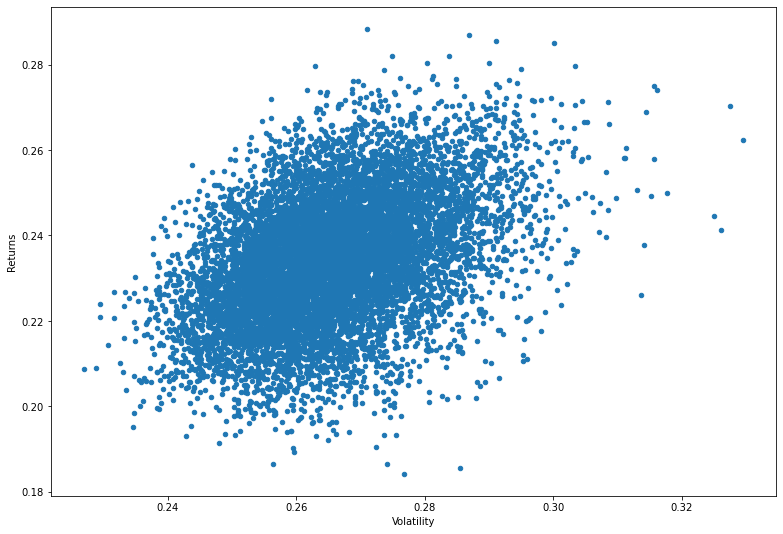

In [10]:
ports = pd.DataFrame({'Returns': p_ret, 'Volatility': p_vol})
ports.plot(x='Volatility', y='Returns', kind='scatter', figsize=(13, 9))

## Select the best portfolio
Highest Sharpe ratio (highest return at a reasonable volatility)

In [11]:
# Return the index with the highest Sharpe Ratio
SR_idx = np.argmax(p_SR) # returns indices of the maximum values 

# With this index, look for the tickers and weights
i = 0 
port_ticker = []
port_perc = []
while i < num_stocks:
    port_perc.append(p_wt[SR_idx][i] * 100)
    port_ticker.append(portfolio[i])
    i += 1

# port_ticker = np.array(port_ticker)
# port_perc = np.array(port_perc)

ult_port = pd.DataFrame({'Stock': port_ticker, '%': port_perc})

# Sort and print
print(ult_port.sort_values(by=['%'], ascending = False))

print("Volatility: ", p_vol[SR_idx] * 100, "%")
print("Return: ", p_ret[SR_idx] * 100, "%")
print("Risk-free return: ", risk_free_rate * 100, "%")

   Stock          %
4    FCX  18.208540
10  COST  16.521910
5    NSA  15.937158
9    PLD  10.318614
1     VG   9.793897
11   MKC   6.103755
8   REXR   4.632041
12   HSY   4.270145
2     MU   4.039945
7   CBRE   3.627251
0    LYV   3.226708
6    EXR   2.396845
3    LIN   0.625856
13   EXC   0.297336
Volatility:  27.09701055154718 %
Return:  28.8364810482363 %
Risk-free return:  1.25 %
